# НТО ИИ 2025-2026: Командный этап (Baseline)

Единый ноутбук с полным циклом решения командной задачи: от загрузки данных до формирования файла с ответами.

### Структура решения:
1. **Конфигурация**: Настройка путей и параметров.
2. **Утилиты**: Вспомогательные функции.
3. **Загрузка данных**: Чтение и объединение таблиц.
4. **Генерация признаков**: Создание фичей для обучения (текстовые, агрегации).
5. **Валидация**: Стратегия проверки качества (Temporal Split) и метрики.
6. **Обучение**: Тренировка модели LightGBM.
7. **Предсказание**: Генерация сабмита для тестовой выборки.
8. **Проверка**: Техническая валидация файла ответов.

In [1]:
# !unzip stage2_team_data.zip

In [2]:
!pip install catboost

In [3]:
import pandas as pd
train = pd.read_csv('/content/public/train.csv')
train.head()

,user_id,book_id,has_read,rating,timestamp
0,3870,310170,0,0,2008-04-27 21:06:16
1,3870,306406,0,0,2008-06-07 11:51:01
2,4091,195676,0,0,2008-08-06 00:40:55
3,3870,554261,1,8,2008-08-07 09:16:12
4,3870,33078,1,2,2008-08-07 09:17:20


In [4]:
pd.read_csv('/content/public/books.csv').head()

,book_id,title,author_id,author_name,publication_year,language,publisher,avg_rating
0,20,Вероника решает умереть,21,Пауло Коэльо,2019,119,9,4.95082
1,35,Самое жуткое приключение,33,Р. Л. Стайн,2002,119,122,0.00000
2,52,Разводящий Апокалипсиса,50,Сергей Щеглов,2001,119,9,6.00000
3,54,Вердикт,14088,Джон Гришэм,2021,119,9,4.00000
4,69,Как выжить с мужчиной,69,Иоанна Хмелевская,2001,119,157,8.00000


In [5]:
users = pd.read_csv('/content/public/users.csv')
users.head()

,user_id,gender,age
0,151,2,45
1,210,2,23
2,560,2,9
3,1380,1,44
4,1850,2,9


In [6]:
sample_sub = pd.read_csv('/content/public/sample_submission.csv')
sample_sub.head()

,user_id,book_id_list
0,210,"11936,254097,709075,840500,971259,1037723,1074..."
1,1380,"11936,254097,709075,840500,971259,1037723,1074..."


In [7]:
candidates = pd.read_csv('/content/public/candidates.csv')
candidates.head()

,user_id,book_id_list
0,210,"11936,254097,709075,840500,971259,1037723,1074..."
1,1380,"8369,28302,145975,482934,625734,998313,1098150..."
2,2050,"4902,8369,18790,308364,317849,460492,822326,86..."
3,2740,"39221,112023,149611,162418,181062,317050,43565..."
4,4621,"28638,28639,28642,28901,31479,307058,475353,57..."


In [8]:
# === ИМПОРТЫ ===
import pandas as pd
import numpy as np
import gc
import warnings
from pathlib import Path
from typing import Tuple, Set
from tqdm import tqdm
from catboost import CatBoostRanker
import joblib

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

# === КОНФИГУРАЦИЯ ===
class constants:
    # Файлы
    TRAIN_FILENAME = "train.csv"
    TARGETS_FILENAME = "targets.csv"
    CANDIDATES_FILENAME = "candidates.csv"
    USER_DATA_FILENAME = "users.csv"
    BOOK_DATA_FILENAME = "books.csv"
    BOOK_GENRES_FILENAME = "book_genres.csv"
    BOOK_DESCRIPTIONS_FILENAME = "book_descriptions.csv"
    SUBMISSION_FILENAME = "submission.csv"
    PROCESSED_DATA_FILENAME = "processed_features.parquet"
    TFIDF_VECTORIZER_FILENAME = "tfidf_vectorizer.pkl"

    # Колонки
    COL_USER_ID = "user_id"
    COL_BOOK_ID = "book_id"
    COL_HAS_READ = "has_read"
    COL_TIMESTAMP = "timestamp"
    COL_RELEVANCE = "relevance"
    COL_SOURCE = "source"
    COL_BOOK_ID_LIST = "book_id_list"
    COL_DESCRIPTION = "description"
    COL_GENRE_ID = "genre_id"
    COL_AUTHOR_ID = "author_id"
    COL_AVG_RATING = "avg_rating"
    COL_PUBLICATION_YEAR = "publication_year"
    COL_GENDER = "gender"
    COL_AGE = "age"
    COL_LANGUAGE = "language"
    COL_PUBLISHER = "publisher"

    # Фичи
    F_USER_BOOK_INTERACTION = "f_user_book_interaction"
    F_BOOK_GENRES_COUNT = "f_book_genres_count"

    # Значения
    VAL_SOURCE_TRAIN = "train"
    MAX_RANKING_LENGTH = 20
    MISSING_CAT_VALUE = "-1"

class config:
    ROOT_DIR = Path(".")
    DATA_DIR = ROOT_DIR / "public"
    RAW_DATA_DIR = DATA_DIR / ""
    PROCESSED_DATA_DIR = DATA_DIR / "processed"
    MODEL_DIR = Path("output/models")
    SUBMISSION_DIR = Path("output/submissions")

    PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    SUBMISSION_DIR.mkdir(parents=True, exist_ok=True)

    RANDOM_STATE = 42
    TEMPORAL_SPLIT_RATIO = 0.8
    EARLY_STOPPING_ROUNDS = 50

    # TF-IDF
    TFIDF_MAX_FEATURES = 300
    TFIDF_MIN_DF = 2
    TFIDF_MAX_DF = 0.95
    TFIDF_NGRAM_RANGE = (1, 2)

    # CatBoost
    CB_PARAMS = {
        "loss_function": "YetiRank",
        "eval_metric": "NDCG:top=20",
        "iterations": 5000,
        "learning_rate": 0.03,
        "depth": 12,
        "random_seed": RANDOM_STATE,
        "task_type": "GPU",
        "devices": "0",
        "early_stopping_rounds": EARLY_STOPPING_ROUNDS,
        "verbose": 100,
    }

# === УТИЛИТЫ ===
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and "category" not in str(col_type) and "datetime" not in str(col_type):
            c_min, c_max = df[col].min(), df[col].max()
            if "int" in str(col_type):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            elif "float" in str(col_type):
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    return df

# === ЗАГРУЗКА ДАННЫХ ===
def load_and_merge_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    dtype_spec = {
        constants.COL_USER_ID: "int32",
        constants.COL_BOOK_ID: "int32",
        constants.COL_HAS_READ: "int32",
        constants.COL_GENDER: "category",
        constants.COL_AGE: "float32",
        constants.COL_AUTHOR_ID: "int32",
        constants.COL_PUBLICATION_YEAR: "float32",
        constants.COL_LANGUAGE: "category",
        constants.COL_PUBLISHER: "category",
        constants.COL_AVG_RATING: "float32",
        constants.COL_GENRE_ID: "int16",
    }

    train_df = pd.read_csv(
        config.RAW_DATA_DIR / constants.TRAIN_FILENAME,
        dtype={k: v for k, v in dtype_spec.items() if k in [constants.COL_USER_ID, constants.COL_BOOK_ID, constants.COL_HAS_READ]},
        parse_dates=[constants.COL_TIMESTAMP],
    )
    train_df[constants.COL_RELEVANCE] = train_df[constants.COL_HAS_READ].map({1: 2, 0: 1}).astype("int8")
    train_df[constants.COL_SOURCE] = constants.VAL_SOURCE_TRAIN

    user_data_df = pd.read_csv(config.RAW_DATA_DIR / constants.USER_DATA_FILENAME)
    book_data_df = pd.read_csv(config.RAW_DATA_DIR / constants.BOOK_DATA_FILENAME).drop_duplicates(subset=[constants.COL_BOOK_ID])

    train_df = train_df.merge(user_data_df, on=constants.COL_USER_ID, how="left")
    train_df = train_df.merge(book_data_df, on=constants.COL_BOOK_ID, how="left")

    targets_df = pd.read_csv(config.RAW_DATA_DIR / constants.TARGETS_FILENAME, dtype={constants.COL_USER_ID: "int32"})
    candidates_df = pd.read_csv(config.RAW_DATA_DIR / constants.CANDIDATES_FILENAME, dtype={constants.COL_USER_ID: "int32"})
    book_genres_df = pd.read_csv(config.RAW_DATA_DIR / constants.BOOK_GENRES_FILENAME)
    book_descriptions_df = pd.read_csv(config.RAW_DATA_DIR / constants.BOOK_DESCRIPTIONS_FILENAME)

    return train_df, targets_df, candidates_df, book_genres_df, book_descriptions_df

def expand_candidates(candidates_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in candidates_df.iterrows():
        if pd.isna(r[constants.COL_BOOK_ID_LIST]) or not r[constants.COL_BOOK_ID_LIST].strip():
            continue
        books = [int(x.strip()) for x in r[constants.COL_BOOK_ID_LIST].split(",") if x.strip()]
        for b in books:
            rows.append({constants.COL_USER_ID: r[constants.COL_USER_ID], constants.COL_BOOK_ID: b})
    return pd.DataFrame(rows).astype({constants.COL_USER_ID: "int32", constants.COL_BOOK_ID: "int32"})

# === FEATURE ENGINEERING ===
def add_interaction_feature(df: pd.DataFrame, train_df: pd.DataFrame) -> pd.DataFrame:
    pairs = set(zip(train_df[constants.COL_USER_ID], train_df[constants.COL_BOOK_ID]))
    df[constants.F_USER_BOOK_INTERACTION] = [
        1 if (u, b) in pairs else 0
        for u, b in zip(df[constants.COL_USER_ID], df[constants.COL_BOOK_ID])
    ]
    return df

def add_genre_features(df: pd.DataFrame, book_genres_df: pd.DataFrame, train_df: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет:
      - f_book_genres_count: кол-во жанров у книги
      - user_genre_weighted_mean_sum: sum_g w(u,g|b) * mean_rel(u,g),
        где w(u,g|b) = cnt(u,g) / sum_{g' in genres(b)} cnt(u,g')
      - book_genre_global_mean_avg: среднее глобальных mean(relevance) по жанрам книги
    """
    eps = 1e-6

    # 1) сколько жанров у книги
    genre_counts = book_genres_df.groupby(constants.COL_BOOK_ID)[constants.COL_GENRE_ID].count().reset_index()
    genre_counts.columns = [constants.COL_BOOK_ID, constants.F_BOOK_GENRES_COUNT]
    out = df.merge(genre_counts, on=constants.COL_BOOK_ID, how="left")

    # 2) train с жанрами
    train_ug = train_df[[constants.COL_USER_ID, constants.COL_BOOK_ID, constants.COL_RELEVANCE]].merge(
        book_genres_df[[constants.COL_BOOK_ID, constants.COL_GENRE_ID]],
        on=constants.COL_BOOK_ID,
        how="left",
    )

    # 2a) user-genre stats: mean relevance + count interactions
    user_genre_stats = (
        train_ug.groupby([constants.COL_USER_ID, constants.COL_GENRE_ID])[constants.COL_RELEVANCE]
        .agg(["mean", "count"])
        .reset_index()
        .rename(columns={"mean": "user_genre_mean_rel", "count": "user_genre_cnt"})
    )

    # 2b) global genre mean relevance
    genre_global_mean = (
        train_ug.groupby(constants.COL_GENRE_ID)[constants.COL_RELEVANCE]
        .mean()
        .reset_index()
        .rename(columns={constants.COL_RELEVANCE: "genre_global_mean_rel"})
    )

    # 2c) для каждой книги: среднее глобальных средних по её жанрам
    book_genre_global_mean = (
        book_genres_df.merge(genre_global_mean, on=constants.COL_GENRE_ID, how="left")
        .groupby(constants.COL_BOOK_ID)["genre_global_mean_rel"]
        .mean()
        .reset_index()
        .rename(columns={"genre_global_mean_rel": "book_genre_global_mean_avg"})
    )
    out = out.merge(book_genre_global_mean, on=constants.COL_BOOK_ID, how="left")

    # 3) развернуть (user, book) -> (user, book, genre)
    tmp = out[[constants.COL_USER_ID, constants.COL_BOOK_ID]].merge(
        book_genres_df[[constants.COL_BOOK_ID, constants.COL_GENRE_ID]],
        on=constants.COL_BOOK_ID,
        how="left",
    )

    # 4) приклеить user-genre stats (если жанр не встречался у пользователя -> 0)
    tmp = tmp.merge(
        user_genre_stats,
        on=[constants.COL_USER_ID, constants.COL_GENRE_ID],
        how="left",
    )
    tmp["user_genre_cnt"] = tmp["user_genre_cnt"].fillna(0).astype("float32")
    tmp["user_genre_mean_rel"] = tmp["user_genre_mean_rel"].fillna(0).astype("float32")

    # 5) веса по жанрам внутри конкретной книги
    denom = tmp.groupby([constants.COL_USER_ID, constants.COL_BOOK_ID])["user_genre_cnt"].transform("sum")
    tmp["user_genre_w"] = tmp["user_genre_cnt"] / (denom + eps)

    # 6) итоговая фича: взвешенная сумма mean_rel
    tmp["wg_component"] = tmp["user_genre_w"] * tmp["user_genre_mean_rel"]

    feat = (
        tmp.groupby([constants.COL_USER_ID, constants.COL_BOOK_ID])["wg_component"]
        .sum()
        .reset_index()
        .rename(columns={"wg_component": "user_genre_weighted_mean_sum"})
    )

    out = out.merge(feat, on=[constants.COL_USER_ID, constants.COL_BOOK_ID], how="left")

    # 7) fillna/types
    out[constants.F_BOOK_GENRES_COUNT] = out[constants.F_BOOK_GENRES_COUNT].fillna(0).astype("int16")
    out["user_genre_weighted_mean_sum"] = out["user_genre_weighted_mean_sum"].fillna(0).astype("float32")
    out["book_genre_global_mean_avg"] = out["book_genre_global_mean_avg"].fillna(0).astype("float32")

    return out


def add_text_features(df: pd.DataFrame, train_df: pd.DataFrame, desc_df: pd.DataFrame) -> pd.DataFrame:
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer_path = config.MODEL_DIR / constants.TFIDF_VECTORIZER_FILENAME

    train_books = set(train_df[constants.COL_BOOK_ID])
    train_desc = desc_df[desc_df[constants.COL_BOOK_ID].isin(train_books)].copy()
    train_desc[constants.COL_DESCRIPTION] = train_desc[constants.COL_DESCRIPTION].fillna("")

    if vectorizer_path.exists():
        vectorizer = joblib.load(vectorizer_path)
    else:
        vectorizer = TfidfVectorizer(
            max_features=config.TFIDF_MAX_FEATURES,
            min_df=config.TFIDF_MIN_DF,
            max_df=config.TFIDF_MAX_DF,
            ngram_range=config.TFIDF_NGRAM_RANGE,
        )
        vectorizer.fit(train_desc[constants.COL_DESCRIPTION])
        joblib.dump(vectorizer, vectorizer_path)

    all_desc = desc_df[[constants.COL_BOOK_ID, constants.COL_DESCRIPTION]].fillna("")
    desc_map = dict(zip(all_desc[constants.COL_BOOK_ID], all_desc[constants.COL_DESCRIPTION]))
    texts = df[constants.COL_BOOK_ID].map(desc_map).fillna("")
    tfidf = vectorizer.transform(texts)

    tfidf_df = pd.DataFrame(
        tfidf.toarray(),
        columns=[f"tfidf_{i}" for i in range(tfidf.shape[1])],
        index=df.index
    )
    return pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

def add_aggregate_features(df: pd.DataFrame, train_df: pd.DataFrame) -> pd.DataFrame:
    eps = 1e-6

    # базовые агрегаты (+ std)
    user_agg = (
        train_df.groupby(constants.COL_USER_ID)[constants.COL_RELEVANCE]
        .agg(["mean", "count", "std"])
        .reset_index()
    )
    user_agg.columns = [constants.COL_USER_ID, "user_relevance_mean", "user_relevance_count", "user_relevance_std"]

    book_agg = (
        train_df.groupby(constants.COL_BOOK_ID)[constants.COL_RELEVANCE]
        .agg(["mean", "count", "std"])
        .reset_index()
    )
    book_agg.columns = [constants.COL_BOOK_ID, "book_relevance_mean", "book_relevance_count", "book_relevance_std"]

    # === USER counts/shares ===
    user_counts = (
        train_df.pivot_table(
            index=constants.COL_USER_ID,
            columns=constants.COL_RELEVANCE,
            values=constants.COL_BOOK_ID,
            aggfunc="count",
            fill_value=0,
        )
        .rename(columns={1: "user_count1", 2: "user_count2"})
        .reset_index()
    )
    for c in ["user_count1", "user_count2"]:
        if c not in user_counts.columns:
            user_counts[c] = 0

    user_counts["user_total"] = user_counts["user_count1"] + user_counts["user_count2"]
    user_counts["user_share1"] = user_counts["user_count1"] / (user_counts["user_total"] + eps)
    user_counts["user_share2"] = user_counts["user_count2"] / (user_counts["user_total"] + eps)

    # === BOOK counts/shares ===
    book_counts = (
        train_df.pivot_table(
            index=constants.COL_BOOK_ID,
            columns=constants.COL_RELEVANCE,
            values=constants.COL_USER_ID,
            aggfunc="count",
            fill_value=0,
        )
        .rename(columns={1: "book_count1", 2: "book_count2"})
        .reset_index()
    )
    for c in ["book_count1", "book_count2"]:
        if c not in book_counts.columns:
            book_counts[c] = 0

    book_counts["book_total"] = book_counts["book_count1"] + book_counts["book_count2"]
    book_counts["book_share1"] = book_counts["book_count1"] / (book_counts["book_total"] + eps)
    book_counts["book_share2"] = book_counts["book_count2"] / (book_counts["book_total"] + eps)

    # === AUTHOR агрегаты ===
    author_agg = train_df.groupby(constants.COL_AUTHOR_ID)[constants.COL_RELEVANCE].agg(["mean"]).reset_index()
    author_agg.columns = [constants.COL_AUTHOR_ID, "author_relevance_mean"]

    author_counts = (
        train_df.pivot_table(
            index=constants.COL_AUTHOR_ID,
            columns=constants.COL_RELEVANCE,
            values=constants.COL_BOOK_ID,
            aggfunc="count",
            fill_value=0,
        )
        .rename(columns={1: "author_count1", 2: "author_count2"})
        .reset_index()
    )
    for c in ["author_count1", "author_count2"]:
        if c not in author_counts.columns:
            author_counts[c] = 0

    author_counts["author_total"] = author_counts["author_count1"] + author_counts["author_count2"]
    author_counts["author_share1"] = author_counts["author_count1"] / (author_counts["author_total"] + eps)
    author_counts["author_share2"] = author_counts["author_count2"] / (author_counts["author_total"] + eps)

    # === USER x AUTHOR mean relevance ===
    user_author_agg = (
        train_df.groupby([constants.COL_USER_ID, constants.COL_AUTHOR_ID])[constants.COL_RELEVANCE]
        .agg(["mean", "count"])
        .reset_index()
    )
    user_author_agg.columns = [
        constants.COL_USER_ID,
        constants.COL_AUTHOR_ID,
        "user_author_relevance_mean",
        "user_author_relevance_count",
    ]

    # === merge ===
    df = df.merge(user_agg, on=constants.COL_USER_ID, how="left")
    df = df.merge(book_agg, on=constants.COL_BOOK_ID, how="left")
    df = df.merge(user_counts, on=constants.COL_USER_ID, how="left")
    df = df.merge(book_counts, on=constants.COL_BOOK_ID, how="left")

    df = df.merge(author_agg, on=constants.COL_AUTHOR_ID, how="left")
    df = df.merge(author_counts, on=constants.COL_AUTHOR_ID, how="left")

    df = df.merge(user_author_agg, on=[constants.COL_USER_ID, constants.COL_AUTHOR_ID], how="left")

    # === fillna/types ===
    int_cols = [
        "user_total", "book_total", "author_total",
        "user_relevance_count", "book_relevance_count",
        "user_author_relevance_count",
    ]
    float_cols = [
        "user_share1", "user_share2", "book_share1", "book_share2", "author_share1", "author_share2",
        "user_relevance_mean", "book_relevance_mean", "author_relevance_mean",
        "user_author_relevance_mean",
        "user_relevance_std", "book_relevance_std",
    ]

    for c in int_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0).astype("int32")

    for c in float_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0).astype("float32")

    return df




def create_full_features(df: pd.DataFrame, train_df: pd.DataFrame, book_genres_df, desc_df) -> pd.DataFrame:
    df = add_interaction_feature(df, train_df)
    df = add_genre_features(df, book_genres_df, train_df)  # <-- UPDATED
    # df = add_text_features(df, train_df, desc_df)
    df = add_aggregate_features(df, train_df)
    return df

# === ГЕНЕРАЦИЯ ГРУПП ДЛЯ RANKER ===
def generate_ranker_data(train_df: pd.DataFrame, book_data_df: pd.DataFrame, book_genres_df, desc_df, top_k_cold: int = 10):
    print("Generating synthetic groups for CatBoost Ranker...")

    # 1. Позитивные
    pos = train_df[[constants.COL_USER_ID, constants.COL_BOOK_ID, constants.COL_RELEVANCE]].copy()

    # 2. Холодные кандидаты: топ-популярные книги, которых нет у пользователя
    book_counts = train_df[constants.COL_BOOK_ID].value_counts().head(5000).index.tolist()
    user_books = train_df.groupby(constants.COL_USER_ID)[constants.COL_BOOK_ID].apply(set).to_dict()

    cold_rows = []
    for user_id in tqdm(train_df[constants.COL_USER_ID].unique(), desc="Generating cold candidates"):
        known = user_books.get(user_id, set())
        cold_candidates = [b for b in book_counts if b not in known][:top_k_cold]
        for b in cold_candidates:
            cold_rows.append({constants.COL_USER_ID: user_id, constants.COL_BOOK_ID: b, constants.COL_RELEVANCE: 0})

    cold = pd.DataFrame(cold_rows)
    full = pd.concat([pos, cold], ignore_index=True)

    # Добавить метаданные
    full = full.merge(book_data_df, on=constants.COL_BOOK_ID, how="left")
    full = create_full_features(full, train_df, book_genres_df, desc_df)

    # Группы
    full = full.sort_values(constants.COL_USER_ID).reset_index(drop=True)
    group_id = full[constants.COL_USER_ID].values  # или .tolist()
    return full, group_id


# === ИНФЕРЕНС ===
def predict_submission():
    model = CatBoostRanker()
    model.load_model(config.MODEL_DIR / "catboost_ranker.cbm")
    feature_cols = joblib.load(config.MODEL_DIR / "feature_cols.pkl")

    # Загрузка данных
    train_df, targets_df, candidates_df, book_genres_df, desc_df = load_and_merge_data()
    book_data_df = pd.read_csv(config.RAW_DATA_DIR / constants.BOOK_DATA_FILENAME).drop_duplicates(subset=[constants.COL_BOOK_ID])

    # Расширить candidates
    candidates_pairs = expand_candidates(candidates_df)
    candidates_pairs = candidates_pairs.merge(book_data_df, on=constants.COL_BOOK_ID, how="left")
    candidates_pairs = create_full_features(candidates_pairs, train_df, book_genres_df, desc_df)

    # Привести к нужным колонкам
    for col in feature_cols:
        if col not in candidates_pairs.columns:
            candidates_pairs[col] = 0
    X_test = candidates_pairs[feature_cols]
    dropping = ['title', 'author_name']
    X_test = X_test.drop(dropping, axis=1)
    # Предсказать
    scores = model.predict(X_test)
    candidates_pairs["score"] = scores

    # Ранжировать
    submission_rows = []
    for user_id in tqdm(targets_df[constants.COL_USER_ID]):
        user_df = candidates_pairs[candidates_pairs[constants.COL_USER_ID] == user_id]
        if user_df.empty:
            book_list = ""
        else:
            top_k = user_df.nlargest(constants.MAX_RANKING_LENGTH, "score")
            book_list = ",".join(top_k[constants.COL_BOOK_ID].astype(str))
        submission_rows.append({constants.COL_USER_ID: user_id, constants.COL_BOOK_ID_LIST: book_list})

    # Сохранить
    sub_df = pd.DataFrame(submission_rows)
    sub_path = config.SUBMISSION_DIR / constants.SUBMISSION_FILENAME
    sub_df.to_csv(sub_path, index=False)
    print(f"Submission saved to {sub_path}")

    # Валидация формата
    validate_submission_format(sub_df)
    return scores, candidates_df

def validate_submission_format(df: pd.DataFrame) -> None:
    required = {"user_id", "book_id_list"}
    assert required.issubset(df.columns), "Missing columns"
    assert not df["user_id"].duplicated().any(), "Duplicate user_id"
    for _, row in df.iterrows():
        s = row["book_id_list"]
        if pd.isna(s) or s == "":
            continue
        books = [int(x.strip()) for x in s.split(",") if x.strip()]
        assert len(books) == len(set(books)), "Duplicates in book list"
        assert len(books) <= constants.MAX_RANKING_LENGTH, "Too many books"
    print("✅ Submission format OK!")



In [9]:
    from catboost import Pool
    train_df, targets_df, candidates_df, book_genres_df, desc_df = load_and_merge_data()
    book_data_df = pd.read_csv(config.RAW_DATA_DIR / constants.BOOK_DATA_FILENAME).drop_duplicates(subset=[constants.COL_BOOK_ID])

    # Временное разделение
    train_df = train_df.sort_values(constants.COL_TIMESTAMP)
    split_idx = int(len(train_df) * config.TEMPORAL_SPLIT_RATIO)
    train_part = train_df.iloc[:split_idx].copy()
    val_part = train_df.iloc[split_idx:].copy()

    print(f"Train part: {len(train_part)}, Val part: {len(val_part)}")

    # Обучение
    X_train, groups_train = generate_ranker_data(train_part, book_data_df, book_genres_df, desc_df)
    y_train = X_train[constants.COL_RELEVANCE]
    feature_cols = [c for c in X_train.columns if c not in [constants.COL_USER_ID, constants.COL_BOOK_ID, constants.COL_RELEVANCE, constants.COL_HAS_READ, constants.COL_TIMESTAMP, constants.COL_SOURCE]]
    X_train = X_train[feature_cols]
    # Валидация
    X_val, groups_val = generate_ranker_data(val_part, book_data_df, book_genres_df, desc_df)
    y_val = X_val[constants.COL_RELEVANCE]
    X_val = X_val[feature_cols]

    # Убедиться, что колонки совпадают
    X_val = X_val.reindex(columns=feature_cols, fill_value=0)
    dropping = ['title', 'author_name']
    X_train = X_train.drop(dropping, axis=1)
    X_val = X_val.drop(dropping, axis=1)
    # CatBoost Ranker
    train_pool = Pool(X_train, y_train, group_id=groups_train,)
    val_pool = Pool(X_val, y_val, group_id=groups_val)
    model = CatBoostRanker(**config.CB_PARAMS)
    model.fit(
        train_pool,
        verbose=100
    )
    # Сохранить
    model.save_model(config.MODEL_DIR / "catboost_ranker.cbm")
    joblib.dump(feature_cols, config.MODEL_DIR / "feature_cols.pkl")
    print("Model saved.")

Train part: 215248, Val part: 53813
Generating synthetic groups for CatBoost Ranker...


Generating cold candidates: 100%|██████████| 6017/6017 [00:02<00:00, 2402.69it/s]


Generating synthetic groups for CatBoost Ranker...


Generating cold candidates: 100%|██████████| 4033/4033 [00:01<00:00, 2130.55it/s]
Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=20;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 67.6ms	remaining: 5m 37s
100:	total: 3.68s	remaining: 2m 58s
200:	total: 6.95s	remaining: 2m 45s
300:	total: 11s	remaining: 2m 51s
400:	total: 14.3s	remaining: 2m 43s
500:	total: 16.9s	remaining: 2m 31s
600:	total: 20.6s	remaining: 2m 30s
700:	total: 23.2s	remaining: 2m 22s
800:	total: 25.8s	remaining: 2m 15s
900:	total: 28.4s	remaining: 2m 9s
1000:	total: 32s	remaining: 2m 7s
1100:	total: 34.9s	remaining: 2m 3s
1200:	total: 37.6s	remaining: 1m 58s
1300:	total: 40.2s	remaining: 1m 54s
1400:	total: 43.4s	remaining: 1m 51s
1500:	total: 46.7s	remaining: 1m 48s
1600:	total: 49.4s	remaining: 1m 44s
1700:	total: 52.1s	remaining: 1m 41s
1800:	total: 54.8s	remaining: 1m 37s
1900:	total: 58.5s	remaining: 1m 35s
2000:	total: 1m 1s	remaining: 1m 31s
2100:	total: 1m 3s	remaining: 1m 28s
2200:	total: 1m 6s	remaining: 1m 24s
2300:	total: 1m 10s	remaining: 1m 22s
2400:	total: 1m 12s	remaining: 1m 18s
2500:	total: 1m 15s	remaining: 1m 15s
2600:	total: 1m 18s	remaining: 1m 12s
2700:	total: 1m

In [10]:
# impscols = sorted(list(zip(X_train.columns, model.get_feature_importance(data=train_pool, type='ShapValues'))), key=lambda x: x[1])
imps = model.get_feature_importance(data=train_pool, type='PredictionValuesChange')
impscols = sorted(list(zip(train_pool.get_feature_names(), imps)), key=lambda x: x[1])

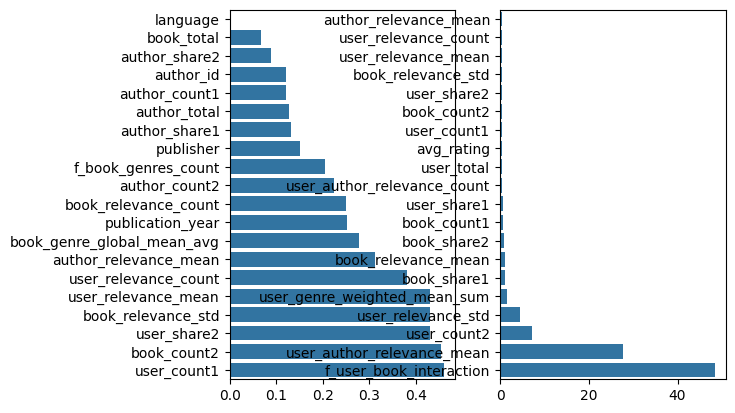

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplot(1,2,1)
sns.barplot(y=[i[0] for i in impscols[:20]], x=[i[1] for i in impscols[:20]])
plt.subplot(1,2,2)
sns.barplot(y=[i[0] for i in impscols[-20:]], x=[i[1] for i in impscols[-20:]])
plt.show()
plt.tight_layout()

In [12]:
scores, cands = predict_submission()

100%|██████████| 3512/3512 [00:07<00:00, 488.35it/s]


Submission saved to output/submissions/submission.csv
✅ Submission format OK!


In [13]:
X_train.head()

,author_id,publication_year,language,publisher,avg_rating,f_user_book_interaction,f_book_genres_count,book_genre_global_mean_avg,user_genre_weighted_mean_sum,user_relevance_mean,user_relevance_count,user_relevance_std,book_relevance_mean,book_relevance_count,book_relevance_std,user_count1,user_count2,user_total,user_share1,user_share2,book_count1,book_count2,book_total,book_share1,book_share2,author_relevance_mean,author_count1,author_count2,author_total,author_share1,author_share2,user_author_relevance_mean,user_author_relevance_count
0,159163,2016,119,164,0.000000,1,2,1.628878,1.350000,1.48,75,0.502964,1.000000,1,0.000000,39,36,75,0.52,0.48,1,0,1,0.999999,0.000000,1.400000,3,2,5,0.600000,0.400000,1.5,2
1,119880,2011,9,2355,0.000000,1,3,1.561347,1.312500,1.48,75,0.502964,1.000000,2,0.000000,39,36,75,0.52,0.48,2,0,2,1.000000,0.000000,1.384615,8,5,13,0.615385,0.384615,1.0,1
2,102183,2016,119,7,0.000000,1,1,1.522054,1.368421,1.48,75,0.502964,1.000000,2,0.000000,39,36,75,0.52,0.48,2,0,2,1.000000,0.000000,1.083333,11,1,12,0.916667,0.083333,1.0,1
3,170773,2016,119,1390,0.000000,1,1,1.586134,1.428571,1.48,75,0.502964,1.000000,1,0.000000,39,36,75,0.52,0.48,1,0,1,0.999999,0.000000,1.000000,1,0,1,0.999999,0.000000,1.0,1
4,620,2019,119,9,5.436559,0,1,1.595964,1.499999,1.48,75,0.502964,1.676692,399,0.468327,39,36,75,0.52,0.48,129,270,399,0.323308,0.676692,1.608008,793,1230,2023,0.391992,0.608008,0.0,0


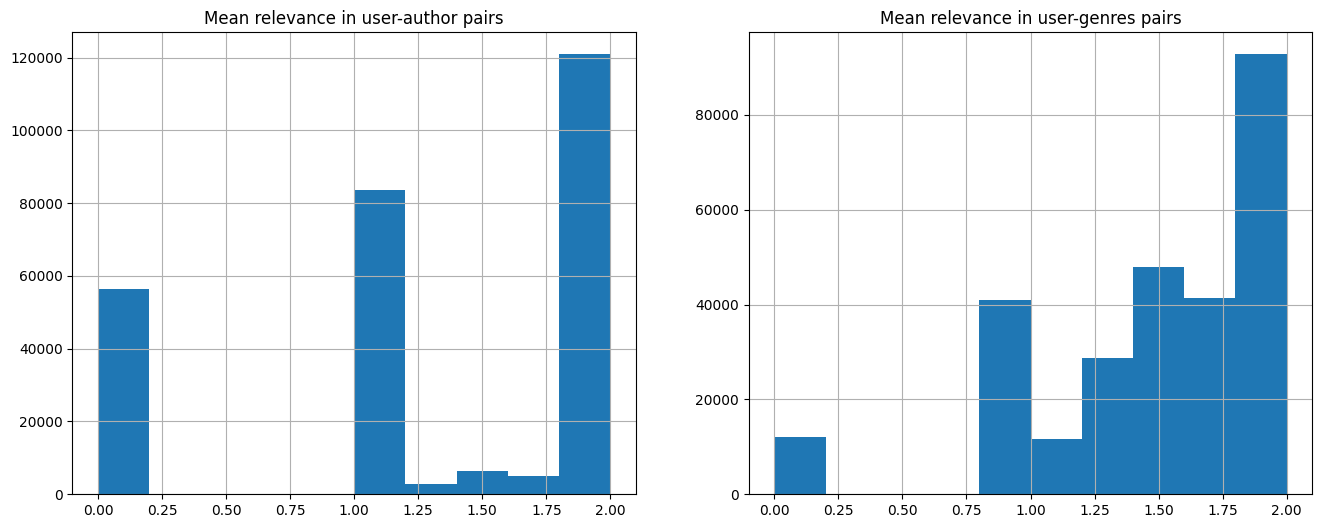

In [14]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(X_train['user_author_relevance_mean'])
plt.title('Mean relevance in user-author pairs')
plt.grid(True)
plt.subplot(1,2,2)
plt.hist(X_train['user_genre_weighted_mean_sum'])
plt.title('Mean relevance in user-genres pairs')
plt.grid(True)
plt.show()

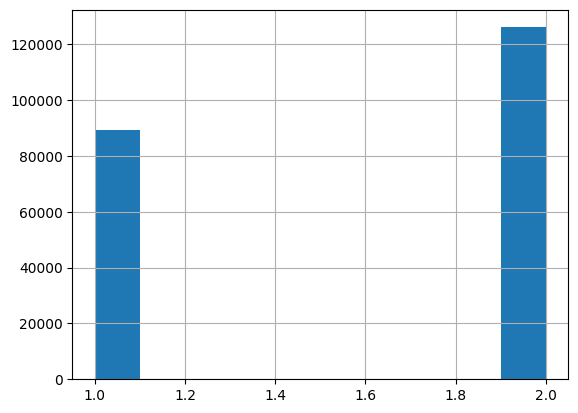

In [15]:
y_train[X_train['f_user_book_interaction'] == 1].hist()
plt.show()